**Problem statement: **To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# The Proposed Solution will follow below 8 steps:
- **Step 1** - Importing all the important libraries
- **Step 2** - Load and extract the Skin Caner dataset to google drive
- **Step 3** - Create Test and Validation dataset
- **Step 4** - Visualize the data and images
- **Step 5** - Model Builing for the provided dataset
- **Step 6** - Application Basic Data Augumentaion Strategy
- **Step 7** - Find the distribution of classes in the training dataset
- **Step 8** - Rectify the class imbalance and build model again

### Step 1 - **Importing all the important libraries**

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.layers import BatchNormalization, Activation, Dropout, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model

from google.colab import drive
from glob import glob

### Step 2 - **Load and extract the Skin Caner dataset to google drive**

In [ ]:
## mounting the google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/Colab Notebooks/Melanoma-Assignment/CNN_assignment.zip" > /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Step 3 - **Create Test and Validation dataset**

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Read the train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Read the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width), label_mode='categorical',
                                                               seed=123,subset="validation",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Step 4 - **Visualize the data and images**
#### Below is two different ways to visualize one instance of all the nine classes present in the dataset

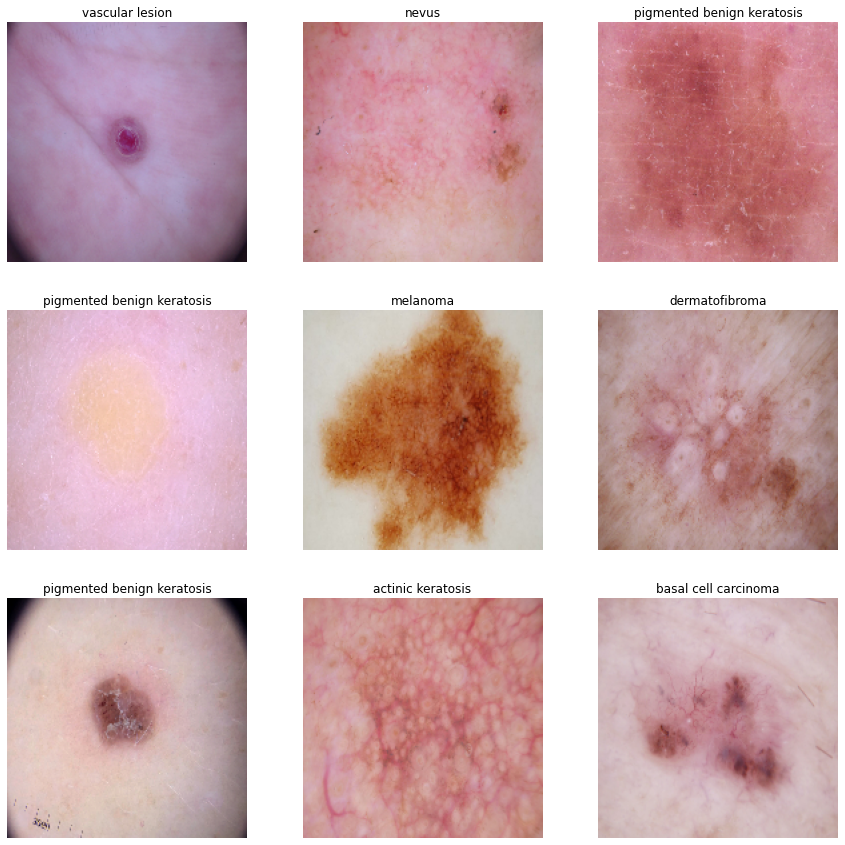

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(np.argmax(labels[i]))])
    plt.axis("off")

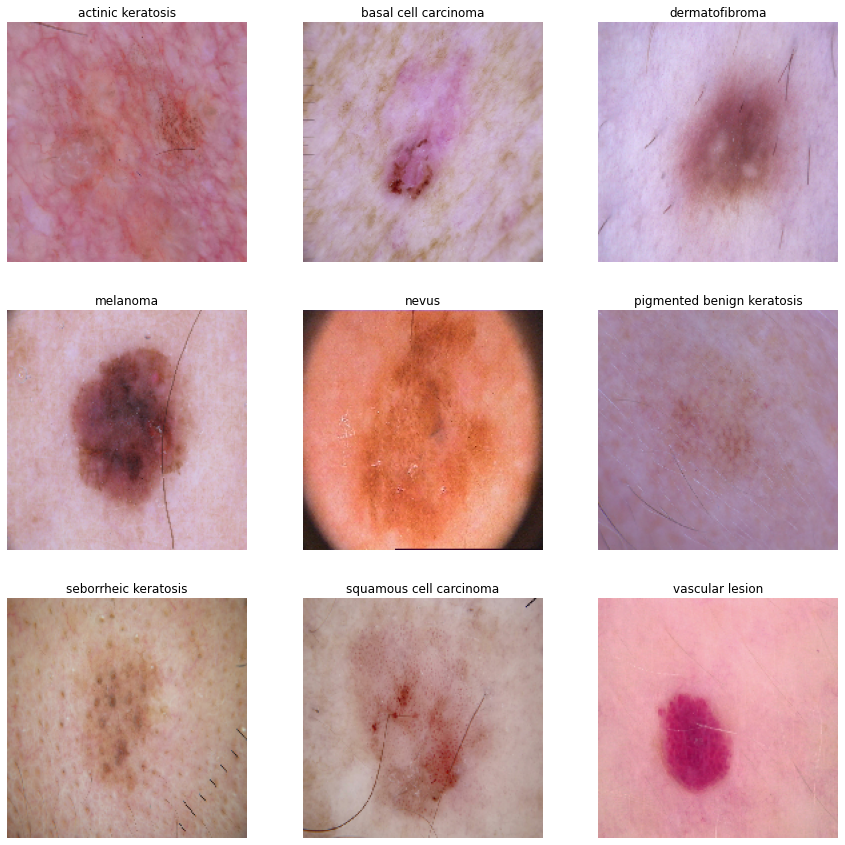

In [ ]:
### your code goes here, you can use training or validation data to visualize

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

### Step 5 - **Model Builing for the provided dataset**

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create the model
###### We will Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
#model.add(layers.Dropout(0.1))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
#model.add(layers.Dropout(0.1))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
#model.add(layers.Dropout(0.1))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

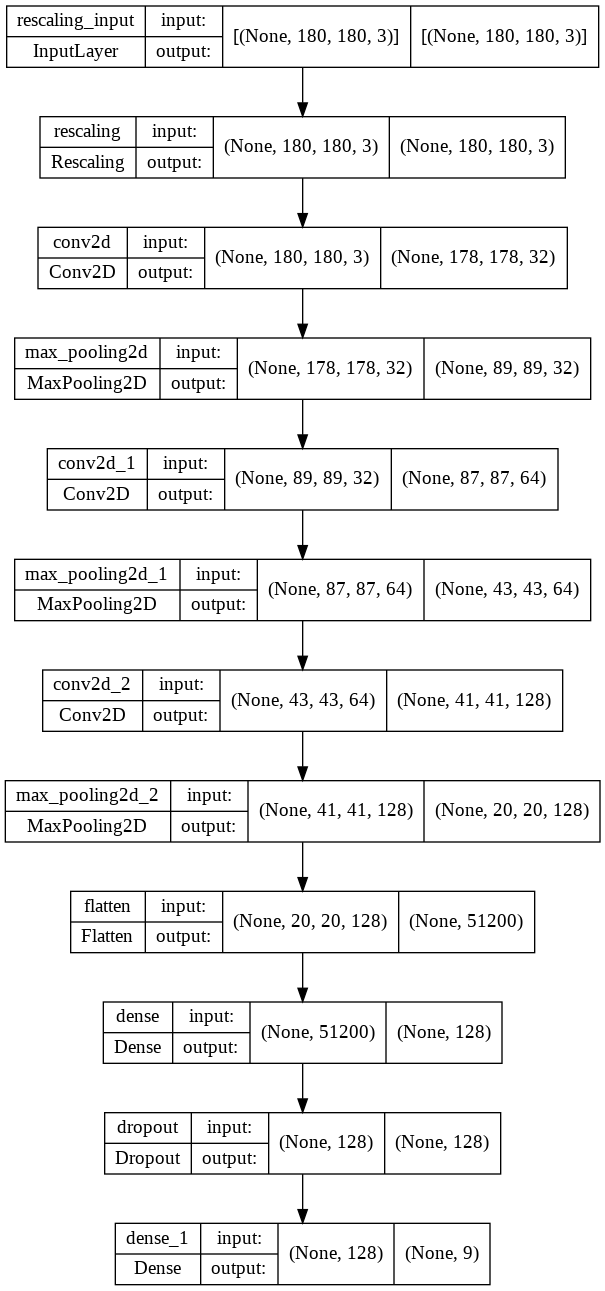

In [ ]:
# vizualizing the model 
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

#### Train the model

In [ ]:
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 27s 88ms/step - loss: 2.0617 - accuracy: 0.2305 - val_loss: 1.9421 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 1.8824 - accuracy: 0.3041 - val_loss: 1.7856 - val_accuracy: 0.3199
Epoch 3/20
56/56 [==============================] - 2s 38ms/step - loss: 1.7125 - accuracy: 0.3717 - val_loss: 1.5902 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 2s 38ms/step - loss: 1.6275 - accuracy: 0.4107 - val_loss: 1.6063 - val_accuracy: 0.4385
Epoch 5/20
56/56 [==============================] - 2s 38ms/step - loss: 1.5921 - accuracy: 0.4381 - val_loss: 1.4523 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 2s 38ms/step - loss: 1.4930 - accuracy: 0.4766 - val_loss: 1.4657 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 2s 38ms/step - loss: 1.3982 - accuracy: 0.5061 - val_loss: 1.3572 - val_accuracy: 0.5324
Epoch 8/20
5

#### Visualizing training results

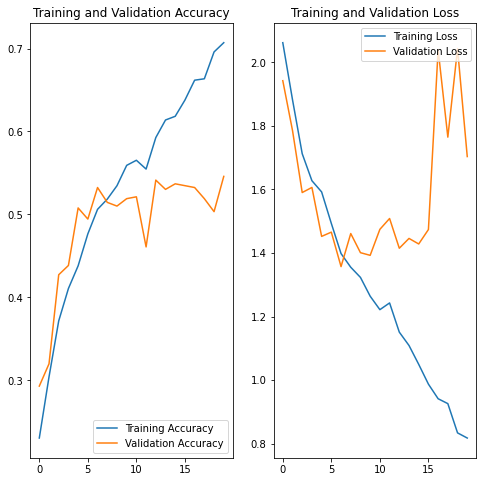

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Findings
We can see from the graph that the train accuracy is going high and train loss is coming down. but, that is the case with validation data.

 #### **Findings:**
1. Train data accuracy is  ~ 70%
2. Validation data accuracy is ~54%
3. There is clear evidence of overfitting
4. Since the total train records are less, so the accuracy mterics is not that good.`

### Step 6 - **Application Basic Data Augumentaion Strategy**

In [ ]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

def augment(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5)
  return image, label

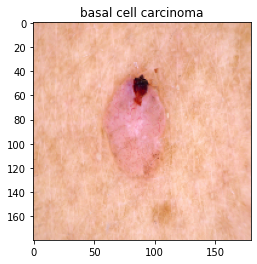

In [ ]:
#picking one image to visualize
image, label = next(iter(train_ds.take(1)))
_ = plt.imshow(image[0].numpy().astype("uint8"))
_ = plt.title(class_names[int(np.argmax(label[0]))])

Rescaling and Resizing of image using tensorflow

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

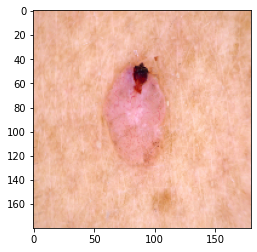

In [ ]:
result = resize_and_rescale(image[0])
_ = plt.imshow(result)

#### Data Augmentation using tensorflow Random Flipflop layer

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# Add the image to a batch.
image_1 = tf.cast(tf.expand_dims(image[0], 0), tf.float32)

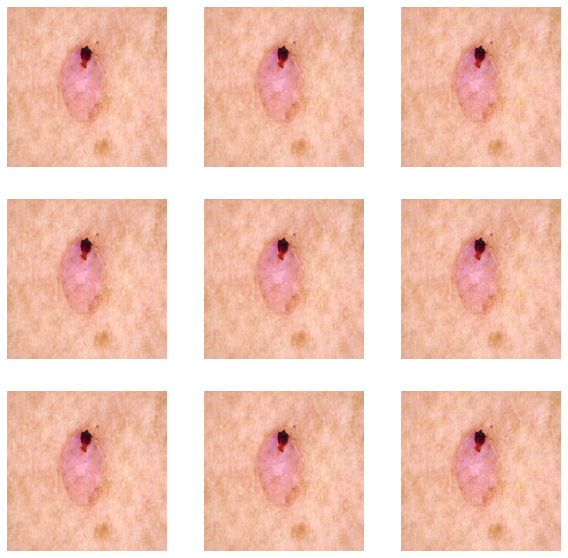

In [ ]:
# picking one image to apply data augumentation and visualize
#Todo, visualize how your augmentation strategy works for one instance of training image.
#Visualize image after data augumentation 
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image_1)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

#### Create the model, compile and train the model after adding augumentaion layer


In [ ]:
#CNN Model Architecture with data augumentation layer added 

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer
model.add(data_augmentation)
#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
#model.add(layers.Dropout(0.1))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
#model.add(layers.Dropout(0.1))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
#model.add(layers.Dropout(0.1))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

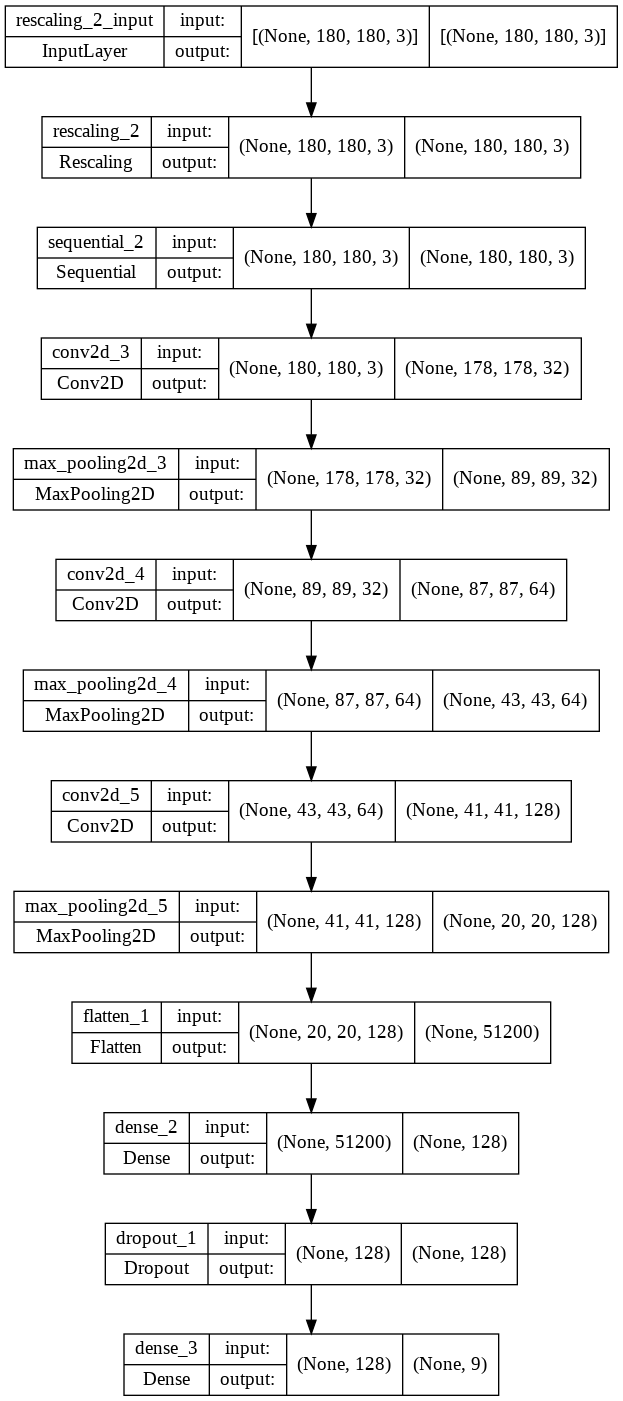

In [ ]:
# vizualizing the model 
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

##### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

##### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 43ms/step - loss: 2.0039 - accuracy: 0.2600 - val_loss: 1.7117 - val_accuracy: 0.4161
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.7638 - accuracy: 0.3711 - val_loss: 1.6160 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6054 - accuracy: 0.4252 - val_loss: 1.5213 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5491 - accuracy: 0.4593 - val_loss: 1.4133 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4337 - accuracy: 0.4950 - val_loss: 1.4024 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3997 - accuracy: 0.5140 - val_loss: 1.3719 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4321 - accuracy: 0.4989 - val_loss: 1.5161 - val_accuracy: 0.4698
Epoch 8/20
56

#### Visualizing the results

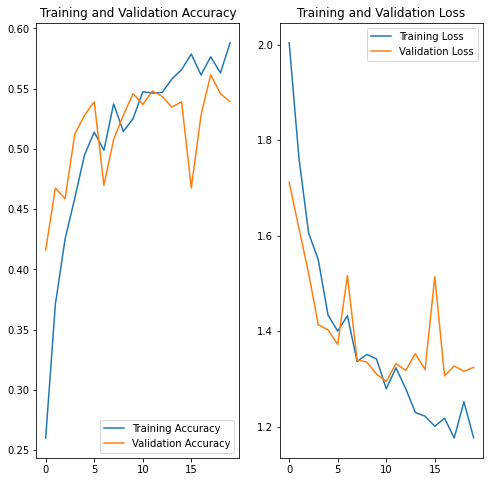

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We haven't seen improvemnet in validation data accuracy and train data accuracy has gone down comparing with the last model. 

### Step 7 - **Find the distribution of classes in the training dataset**.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

In [ ]:
#Visualize the Number of image in each class.
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")
plt.show()

#### There is high imbalence in the number of images belonging to each class. and also the total number of imgaes is lesser when considering training of deep learning model from scratch. 

#### - Which class has the least number of samples? - **seborrheic keratosis**

#### - Which classes dominate the data in terms proportionate number of samples? - **pigmented benign keratosis**


### Step 8 - **Rectify the class imbalance and build model again**
#### **Context:** We are using python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
train_path="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
test_path="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9649


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027559.jpg_4776722e-0b66-4348-92fe-dc3dddb24cb1.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025297.jpg_c89888a1-2eda-41e0-b085-6f84bed8e09d.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027820.jpg_ac85ec5f-d7b5-4102-ae84-2a52ac1e7509.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026538.jpg_266d419f-3c12-4329-a93f-8d7ba7bbb2d3.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025915.jp

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
for i in class_names:
    class_directory = pathlib.Path(os.path.join(train_path, i))
    class_directory_out = pathlib.Path(os.path.join(train_path, i , "output"))
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 1614 samples.
basal cell carcinoma has 1525 samples.
dermatofibroma has 1095 samples.
melanoma has 1438 samples.
nevus has 1357 samples.
pigmented benign keratosis has 1462 samples.
seborrheic keratosis has 1077 samples.
squamous cell carcinoma has 1181 samples.
vascular lesion has 1139 samples.


So, now we have added 1000 images to all the classes to maintain class balance. I have tried with adding 500 images as well. Validation accuracy was little low.  

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset after data augumentation

In [ ]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11888 files belonging to 9 classes.
Using 9511 files for training.


#### Create a validation dataset after augimentation

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11888 files belonging to 9 classes.
Using 2377 files for validation.


#### Create your model (make sure to include normalization)

In [ ]:
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Conv2D(128,(3,3),activation='relu',padding='same'), 
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

#### Train the model

In [ ]:
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/50
298/298 [==============================] - ETA: 0s - loss: 1.9184 - accuracy: 0.2599
Epoch 1: val_accuracy improved from -inf to 0.41859, saving model to model.h5
298/298 [==============================] - 40s 128ms/step - loss: 1.9184 - accuracy: 0.2599 - val_loss: 1.5572 - val_accuracy: 0.4186
Epoch 2/50
297/298 [============================>.] - ETA: 0s - loss: 1.4708 - accuracy: 0.4372
Epoch 2: val_accuracy improved from 0.41859 to 0.42785, saving model to model.h5
298/298 [==============================] - 39s 127ms/step - loss: 1.4703 - accuracy: 0.4374 - val_loss: 1.5373 - val_accuracy: 0.4279
Epoch 3/50
297/298 [============================>.] - ETA: 0s - loss: 1.2792 - accuracy: 0.5152
Epoch 3: val_accuracy improved from 0.42785 to 0.55995, saving model to model.h5
298/298 [==============================] - 40s 131ms/step - loss: 1.2789 - accuracy: 0.5153 - val_loss: 1.2101 - val_accuracy: 0.5599
Epoch 4/50
297/298 [============================>.] - ETA: 0s - loss: 

#### Visualize the model results

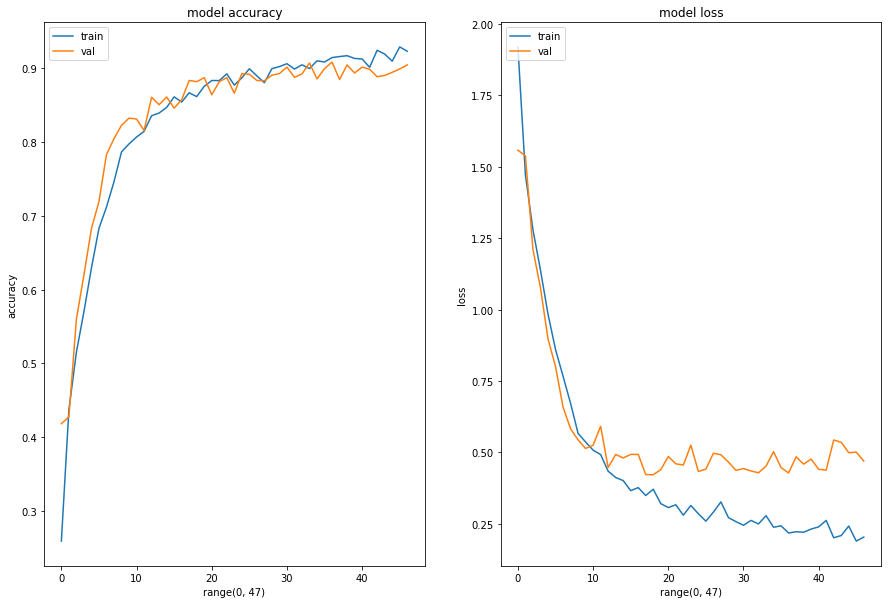

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Observations**:
1. Rebalancing of calsses has helped. 
2. When I added 500 images for each class the validation accuracy was around 82%, but when I increased the image count by 1000 for each class, then the validation accuracy gone up to 90%
3. Train data accuracy is around 91%
4. There is no overfiiting or underfitting. 



#### Validation of the final model with one of the test records

Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


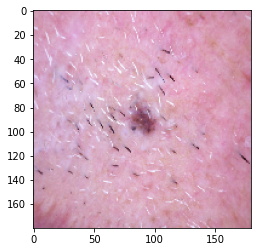

In [ ]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )